# Copernicus Atmosphere using BuildSearchResult plugin

In this tutorial we will show you how to use eodag to download data from providers using [BuildSearchResult](https://eodag.readthedocs.io/en/latest/plugins_reference/generated/eodag.plugins.search.build_search_result.BuildSearchResult.html) `eodag` plugin. You can currently find two providers that uses it, `cop_ads` and `cop_cds`. For this tutorial we will use `cop_ads`, but `cop_cds` is used the same way.

In [1]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
dag.set_preferred_provider("cop_ads")

## Search (build download request)

There are two use case, a search for a product already configured in EODAG, or a search for a dataset not already configured, where you will have a little more to do.

We can add a `variable` (Temperature, `temperature`) and one `model_level` to the request because `CAMS_EAC4` is configured to request for some pre-configured values. Check the dataset available values to make your selection.

> Note: specifying your own variables will completely overwrite default values configured for `CAMS_EAC4` product type.

### Check available queryables and default values:

Available queryables parameters and associated values can be checked using [list_queryables()](https://eodag.readthedocs.io/en/latest/notebooks/api_user_guide/4_search.html#Queryables) method, or through [cop_ads](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form) or [cop_cds](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset) websites:

In [2]:
queryables = dag.list_queryables(provider="cop_ads", productType="CAMS_EAC4")
queryables["variable"]

typing.Annotated[typing.Literal['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'acetone', 'acetone_product', 'aldehydes', 'amine', 'ammonia', 'ammonium', 'black_carbon_aerosol_optical_depth_550nm', 'carbon_monoxide', 'dimethyl_sulfide', 'dinitrogen_pentoxide', 'dust_aerosol_0.03-0.55um_mixing_ratio', 'dust_aerosol_0.55-0.9um_mixing_ratio', 'dust_aerosol_0.9-20um_mixing_ratio', 'dust_aerosol_optical_depth_550nm', 'ethane', 'ethanol', 'ethene', 'formaldehyde', 'formic_acid', 'fraction_of_cloud_cover', 'geopotential', 'high_cloud_cover', 'high_vegetation_cover', 'hydrogen_peroxide', 'hydroperoxy_radical', 'hydrophilic_black_carbon_aerosol_mixing_ratio', 'hydrophilic_organic_matter_aerosol_mixing_ratio', 'hydrophobic_black_carbon_aerosol_mixing_ratio', 'hydrophobic_organic_matter_aerosol_mixing_ratio', 'hydroxyl_radical', 'isoprene', 'lake_cover', 'land_sea_mask', 'lead', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'

Here we can see the list of available values for `variable`, and that the default value configured for `CAMS_EAC4` is `2m_dewpoint_temperature`

### Search from an existing product type:

In [3]:
# Request for all parameters
products_from_product_type, total_count = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
)
print(
    "%s product built %s,\n having variable = %s\nand model_level=%s\n"
    % (
        total_count,
        products_from_product_type[0],
        products_from_product_type[0].properties.get("variable"),
        products_from_product_type[0].properties.get("model_level"),
    )
)
# Request for temperature on one model level
products_from_product_type, total_count = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
    variable="temperature",
    model_level="1",
)
print(
    "%s product built %s,\n having variable = %s\nand model_level=%s\n"
    % (
        total_count,
        products_from_product_type[0],
        products_from_product_type[0].properties.get("variable"),
        products_from_product_type[0].properties.get("model_level"),
    )
)

1 product built EOProduct(id=CAMS_EAC4_20210101_e86a2b26cd2bcf90eaa14d1b9f58592169b10a36, provider=cop_ads),
 having variable = 2m_dewpoint_temperature
and model_level=None

1 product built EOProduct(id=CAMS_EAC4_20210101_5cc16f9d5dbf711e31cda8c77c6efc5414a1c4f1, provider=cop_ads),
 having variable = temperature
and model_level=1



### Search using a custom request:

Here we will use a set of custom parameters corresponding to `CAMS_EAC4`, which should result to the same request sent to ads.

In [4]:
ads_req_params = {
    "dataset": "cams-global-reanalysis-eac4",
    "variable": "temperature",
    "model_level": "1",
    "time": "00:00",
    "format": "grib",
}

products_from_ads_req, total_count = dag.search(
    provider="cop_ads",
    start="2021-01-01",
    end="2021-01-02",
    **ads_req_params,
)
# orderLink property must be the same with the two request methods,
# as they are built from the same ADS request arguments
if (
    products_from_ads_req[0].properties["orderLink"]
    == products_from_product_type[0].properties["orderLink"]
):
    print(
        "Request using productType or directly ADS parameters result to the\n",
        "same orderLink %s"
        % (
            products_from_ads_req[0].properties["orderLink"],
        )
    )

Request using productType or directly ADS parameters result to the
 same orderLink https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4?{"date": "2021-01-01/2021-01-01", "format": "grib", "model_level": 1, "time": "00:00", "variable": "temperature"}


### Send product retrieval request and download when available

- download performed using ADS credentials set in `~/.config/eodag/eodag.yml` as for other EO providers:
```yaml
    cop_ads:
        priority:
        download:
            outputs_prefix: /my/path/to/data/eodag_data
        auth:
            credentials:
                username: my-ads-uid
                password: my-ads-api-key
```
- you can check your request status from https://ads.atmosphere.copernicus.eu/cdsapp#!/yourrequests
- See [support](https://ads.atmosphere.copernicus.eu/cdsapp#!/usersupport) for any problem related to the provider

In [5]:
product_path = dag.download(products_from_product_type[0], wait=0.2)
product_path

0.00B [00:00, ?B/s]

'/data/eodag_data/CAMS_EAC4_20210101_5cc16f9d5dbf711e31cda8c77c6efc5414a1c4f1'

### Open dataset with xarray and [cfgrib](https://github.com/ecmwf/cfgrib), then plot using matplotlib

In [6]:
import os
import xarray as xr

# the product ouput file to load is the only one located in "product_path" directory
ds = xr.load_dataset(os.path.join(product_path, os.listdir(product_path)[0]), engine="cfgrib")
ds

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480)
Coordinates:
    time        datetime64[ns] 2021-01-01
    step        timedelta64[ns] 00:00:00
    hybrid      float64 1.0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
    valid_time  datetime64[ns] 2021-01-01
Data variables:
    t           (latitude, longitude) float32 257.2 257.2 257.2 ... 243.7 243.7
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-08T21:46 GRIB to CDM+CF via cfgrib-0.9.1...

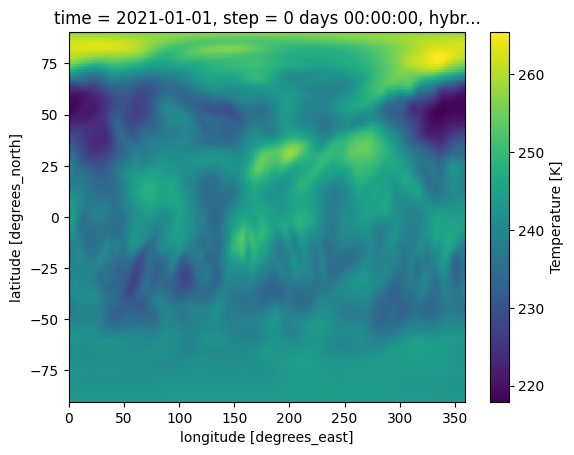

In [7]:
ds.t.plot()